### Training the bottleneck features of VGG16 
##### Keras with Tensorflow backend (channel_last configuration)
Based on:
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html 
- https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069 

We first train the `top_model`, this model will receive as input the outputs of the last convolutional layer of VGG16. Once we train the `top_model` we will combine it with `vgg_model` in a single model, and we will re-train this single model with the layers of VGG frozen.

### 0. Donwload the data sets and prepare the data
A dataset of cats and dogs from an old kaggle competition:
- https://www.kaggle.com/c/dogs-vs-cats/data

Copy 2000/800 validation/training images in the next folder structure
- data
  - train
    - cats
      - 1000 cats
    - dogs
      - 1000 dogs
  - validation
    - cats
      - 400 cats
    - dogs
      - 400 dogs

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
import time

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

### 1. Calculate the inputs for the `top_model` (_bottleneck features_)
The inputs for the `top_model` or _bottleneck features_ will be the output of the last convolutional layer of VGG16. So we first use VGG16 to make the predictions on the training and validation sets.

In [3]:
datagen = ImageDataGenerator(rescale=1. / 255)
# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

start = time.time()
bottleneck_features_train = model.predict_generator(
    generator, nb_train_samples // batch_size, verbose=1)
np.save(open('bottleneck_features_train.npy', 'wb'),
        bottleneck_features_train)
print("ellapsed time in seconds:", (time.time()-start))


generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

start = time.time()
bottleneck_features_validation = model.predict_generator(
    generator, nb_validation_samples // batch_size, verbose=1)
np.save(open('bottleneck_features_validation.npy', 'wb'),
        bottleneck_features_validation)
print("ellapsed time in seconds:", (time.time()-start))

Found 2000 images belonging to 2 classes.
125/125 [==============================] - 351s   
ellapsed time in seconds: 351.3123679161072
Found 800 images belonging to 2 classes.
50/50 [==============================] - 140s   
ellapsed time in seconds: 140.320405960083


### 2. Build and train the `top_model`
The input is the bottleneck features (results of the last conv layer of VGG16) from the previous step. Why we need to train the `top_model` separately? Because we need the weights. This is pointed in the article:

> in order to perform fine-tuning, all layers should start with properly trained weights: for instance you should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.

In [4]:
# make a list of 0s for cats and 1 for dogs, and concatenate them as an array
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

# make a list of 0s for cats and 1 for dogs, and concatenate them as an array
validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

start = time.time()
history = model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)
print("ellapsed time in seconds:", (time.time()-start))

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 2s - loss: 0.6822 - acc: 0.7595 - val_loss: 0.3133 - val_acc: 0.8775
Epoch 2/50
2000/2000 [==============================] - 2s - loss: 0.3730 - acc: 0.8485 - val_loss: 0.5104 - val_acc: 0.8037
Epoch 3/50
2000/2000 [==============================] - 2s - loss: 0.3042 - acc: 0.8835 - val_loss: 0.3107 - val_acc: 0.8875
Epoch 4/50
2000/2000 [==============================] - 2s - loss: 0.2518 - acc: 0.8995 - val_loss: 0.3535 - val_acc: 0.8838
Epoch 5/50
2000/2000 [==============================] - 2s - loss: 0.2178 - acc: 0.9150 - val_loss: 0.8522 - val_acc: 0.7950
Epoch 6/50
2000/2000 [==============================] - 2s - loss: 0.2046 - acc: 0.9290 - val_loss: 0.5013 - val_acc: 0.8438
Epoch 7/50
2000/2000 [==============================] - 3s - loss: 0.1785 - acc: 0.9390 - val_loss: 0.3866 - val_acc: 0.8850
Epoch 8/50
2000/2000 [==============================] - 2s - loss: 0.1758 - ac

### 3. Build the `model` as a combination of `vgg16_model` and `top_model`
Remember to freeze the layers of VGG16 (set them as non-trainable). The reason to freeze the last first layers of VGG16 is explained in the article:
> we choose to only fine-tune the last convolutional block rather than the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. *The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up*, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last one (more specialized features).

In [3]:
from keras import backend as K
from keras.models import Model 

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
# build the VGG16 network
# gracias a include_top=False no se carga las 3 capas iniciales, donde está definida una entrada de 224x224
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
# model.add(top_model)  # 'Model' object has no attribute 'add'
# keras.applications.vgg16 uses Functional API. You can only use the "add" method to a Sequential AP
model = Model(inputs=base_model.input, outputs= top_model(base_model.output))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

<img src="vgg16_modified.png" />

In [4]:
# freeze the first layers up to block5, 
# block5 must be trainable - this block is what we are going to fine-tune!
for layer in model.layers[:15]:
    print(layer.get_config()['name'])
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool


### 4. Train or fine-tune the `model`
> fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features.

In [5]:
from keras import optimizers
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
# using hyperparameters used by others, see http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [6]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [7]:
start = time.time()
# fine-tune the model
# we should get 90-95% in 50 epochs (7.5 hours of training on CPU!)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)
print("ellapsed time in seconds:", (time.time()-start))

Epoch 1/20
125/125 [==============================] - 539s - loss: 0.4736 - acc: 0.8455 - val_loss: 0.4581 - val_acc: 0.8688
Epoch 2/20
125/125 [==============================] - 538s - loss: 0.2618 - acc: 0.8940 - val_loss: 0.3589 - val_acc: 0.9125
Epoch 3/20
125/125 [==============================] - 560s - loss: 0.2156 - acc: 0.9205 - val_loss: 0.3583 - val_acc: 0.9038
Epoch 4/20
125/125 [==============================] - 578s - loss: 0.1633 - acc: 0.9435 - val_loss: 0.3225 - val_acc: 0.9062
Epoch 5/20
125/125 [==============================] - 545s - loss: 0.1285 - acc: 0.9515 - val_loss: 0.3390 - val_acc: 0.9050
Epoch 6/20
125/125 [==============================] - 533s - loss: 0.1305 - acc: 0.9540 - val_loss: 0.2956 - val_acc: 0.9125
Epoch 7/20
125/125 [==============================] - 530s - loss: 0.1067 - acc: 0.9620 - val_loss: 0.3353 - val_acc: 0.9087
Epoch 8/20
125/125 [==============================] - 530s - loss: 0.0842 - acc: 0.9655 - val_loss: 0.2772 - val_acc: 0.9475


In [8]:
model.save_weights("vgg16+topmodel-weights-only.h5")
model.save("vgg16+topmodel.h5")

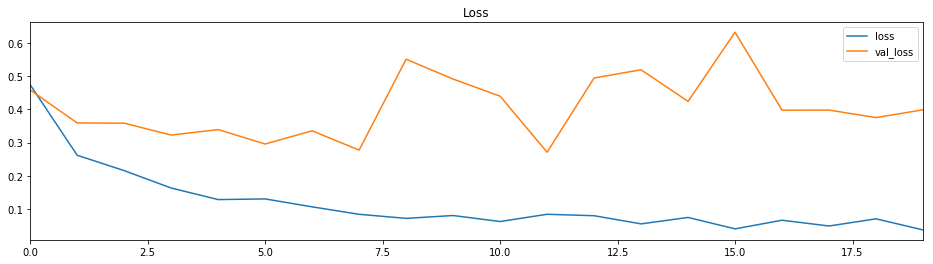

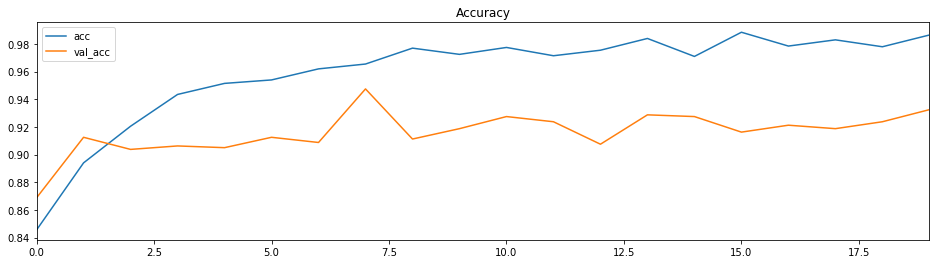

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Loss')
df.plot(y=['acc', 'val_acc'], figsize=(16,4), title='Accuracy')
# df

### 5. Use the `model` to make predictions

In [10]:
from keras.models import load_model
predictor = load_model("vgg16+topmodel.h5")

In [11]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import load_model
# from https://gist.github.com/ragvri/6a28b08b9ad844bc66b90db7d7cebb17
def predict_image_class(predictor, file, w, h):
#     model = applications.VGG16(include_top=False, weights='imagenet')
    x = load_img(file, target_size=(w, h))
    x = img_to_array(x)
    x = np.expand_dims(x, axis=0)
    array = predictor.predict(x)
    print(array)
    if array[0][0] == 1:
        print("dog")
    else:
        print("cat")

In [12]:
predict_image_class(predictor, "data/validation/dogs/dog.12100.jpg", img_width, img_height)
predict_image_class(predictor, "data/validation/cats/cat.12100.jpg", img_width, img_height)

[[ 1.]]
dog
[[ 0.]]
cat


To get above 95% accuracy the article recommends:
> more aggresive data augmentation, 
> more aggressive dropout, 
> use of L1 and L2 regularization (also known as "weight decay"), 
> fine-tuning one more convolutional block (alongside greater regularization)

